Przygotowanie środowiska i danych

In [3]:
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt 
    from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, recall_score, precision_score
    from sklearn.metrics import make_scorer, fbeta_score
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
    from sklearn.svm import SVC
    from sklearn.naive_bayes import GaussianNB
    from sklearn.pipeline import Pipeline
    from sklearn.tree import DecisionTreeClassifier


    def calculations_with_tuning(dataPath):
        # === 1. Wczytanie danych ===
        df = pd.read_csv(dataPath)

        # === 2. Podział na X/y ===
        X = df.drop("DEATH_EVENT", axis=1)
        y = df["DEATH_EVENT"]

        # === 3. Train/test split ===
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, stratify=y, random_state=42
        )

        # === 4. Przygotowanie pipeline i parametrów do strojenia ===
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

        pipelines = {
            'rf': Pipeline([
                ('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=42))
            ]),
            'svm': Pipeline([
                ('scaler', StandardScaler()),
                ('clf', SVC(class_weight='balanced', probability=True, random_state=42))
            ]),
            'ada': Pipeline([
                ('scaler', StandardScaler()),
                ('clf', AdaBoostClassifier(random_state=42))
            ]),
            'nb': Pipeline([
                ('scaler', StandardScaler()),
                ('clf', GaussianNB())
            ]),
            # rf tylko ukierunkowany na minimalizowanie false negative(przeoczenie chorego)
            'rf_f2': Pipeline([
                ('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(random_state=42))  
            ]),
            # ukierunkowany na minimalizowanie fn, ale dla obu datasetów różnice z normalnym są praktycznie niezauważalne
            # 'svm_f2': Pipeline([ 
            #     ('scaler', StandardScaler()),
            #     ('clf', SVC(probability=True, random_state=42))
            # ]),
            'ada_f2': Pipeline([
                ('scaler', StandardScaler()),
                ('clf', AdaBoostClassifier(
                    estimator=DecisionTreeClassifier(class_weight={0:1, 1:5}),
                    random_state=42
                ))
            ])
        }

        param_grids = {
            'rf': {
                'clf__n_estimators': [50, 100],
                'clf__max_depth': [None, 5]
            },
            'svm': {
                'clf__C': [0.1, 1, 10],
                'clf__gamma': ['scale', 'auto']
            },
            'ada': {
                'clf__n_estimators': [50, 100, 200],
                'clf__learning_rate': [0.5, 1.0, 1.5]
            },
            'nb': {
                'clf__var_smoothing': [1e-9, 1e-8, 1e-7]
            },
            'rf_f2': {  # to samo co 'rf', ale z inną metryką scoring
                'clf__n_estimators': [50, 100],
                'clf__max_depth': [None, 5],
                'clf__class_weight': [
                    {0: 1, 1: 5}, # na etapie uczenia model będzie bardziej unikał błędów jednej klasy(przeoczenie chorych)
                    {0: 1, 1: 10}, # 0-zdrowy : waga_bledu, 1-chory : waga
                    {0: 1, 1: 20},
                    {0: 1, 1: 50}
                ]
            },
            # 'svm_f2': {
            #     'clf__C': [0.1, 1, 10],
            #     'clf__gamma': ['scale', 'auto'],
            #     'clf__class_weight': [
            #         {0: 1, 1: 5},
            #         {0: 1, 1: 10},
            #         {0: 1, 1: 20},
            #         {0: 1, 1: 50}
            #     ]
            # }
            'ada_f2': {
                'clf__n_estimators': [50, 100, 200],
                'clf__learning_rate': [0.5, 1.0, 1.5],
                'clf__estimator': [
                    DecisionTreeClassifier(class_weight={0:1, 1:5}),
                    DecisionTreeClassifier(class_weight={0:1, 1:10}),
                    DecisionTreeClassifier(class_weight={0:1, 1:20}),
                    DecisionTreeClassifier(class_weight={0:1, 1:50})
                ]
            }
        }

        best_models = {}

        # Beta < 1 – preferuje precision (mniej FP)
        # Beta > 1 – preferuje recall (mniej FN)    
        fbeta_scorer = make_scorer(fbeta_score, beta=2)
        # === 5. Hyperparameter tuning z GridSearchCV ===
        for name in pipelines:
            print(f"Trening i strojenie: {name}")
            
            # fbeta_scorer tylko dla rf_f2(minimalizowanie false negative kosztem innych)
            scorer = fbeta_scorer if 'f2' in name else 'roc_auc'
            
            grid = GridSearchCV(
                pipelines[name], param_grids[name], cv=cv, scoring=scorer, n_jobs=-1
            )
            grid.fit(X_train, y_train)
            best_models[name] = grid.best_estimator_
            print(f"{name} best params: {grid.best_params_}")

        # === 6. Ocena najlepszych modeli na zbiorze testowym ===
        print("\n=== Metryki na zbiorze testowym (po tuning) ===")
        for name, model in best_models.items():
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            # conf_matrix in plot

            # print(f"\nModel: {name}")
            # print(f"Accuracy: {acc:.3f}")
            # print(f"F1-score: {f1:.3f}")
            # print(f"AUC-ROC: {auc:.3f}")
            # print(f"Precision: {precision:.3f}")
            # print(f"Recall: {recall:.3f}")
            plot_conf_matrix(y_test, y_pred, f"Confusion Matrix: {name}")


        # === 7. Cross-validation after tuning ===
        results = []
        scorers = {
            'Accuracy': 'accuracy',
            'F1': 'f1',
            'Precision': 'precision',
            'Recall': 'recall',
            'AUC': 'roc_auc'
        }
        print("\n=== Cross-validation (Accuracy ± SD) po tuningu ===")
        for name, model in best_models.items():
            row = {"Model": name}
            print(f"\nModel: {name}")
            for metric_name, scorer in scorers.items():
                scores = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)
                row[f"{metric_name} (mean)"] = scores.mean()
                row[f"{metric_name} (std)"] = scores.std()
                print(f"{metric_name}: {scores.mean():.3f} ± {scores.std():.3f}")
            results.append(row)
        
        # === 8. Create DataFrame with results from Cross-validation
        results_df = pd.DataFrame(results)
        return results_df
        # display(results_df)


    def plot_conf_matrix(y_test, y_pred, title):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Healthy', 'Death'], 
                    yticklabels=['Healthy', 'Death'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(title)
        plt.show()



=== Wyniki dla zbioru heart_2.csv ===
Trening i strojenie: rf
rf best params: {'clf__max_depth': 5, 'clf__n_estimators': 100}
Trening i strojenie: svm
svm best params: {'clf__C': 1, 'clf__gamma': 'scale'}
Trening i strojenie: ada


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boos

ada best params: {'clf__learning_rate': 0.5, 'clf__n_estimators': 50}
Trening i strojenie: nb
nb best params: {'clf__var_smoothing': 1e-09}
Trening i strojenie: rf_f2
rf_f2 best params: {'clf__class_weight': {0: 1, 1: 10}, 'clf__max_depth': 5, 'clf__n_estimators': 100}
Trening i strojenie: ada_f2


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boos

ada_f2 best params: {'clf__estimator': DecisionTreeClassifier(class_weight={0: 1, 1: 5}), 'clf__learning_rate': 0.5, 'clf__n_estimators': 50}

=== Metryki na zbiorze testowym (po tuning) ===


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boos

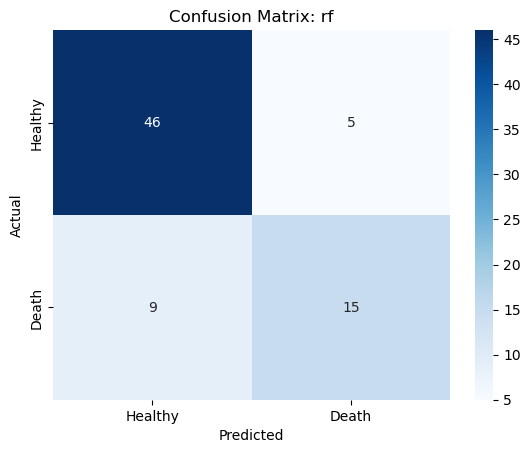

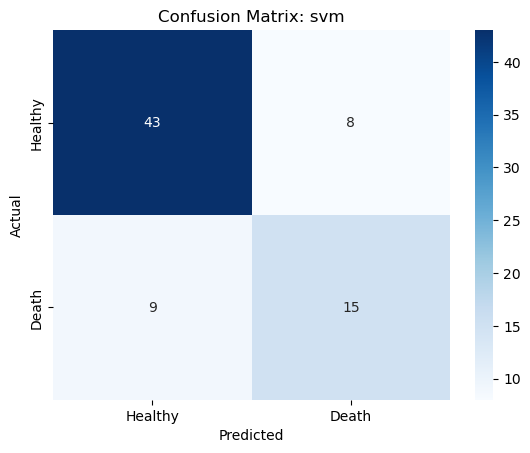

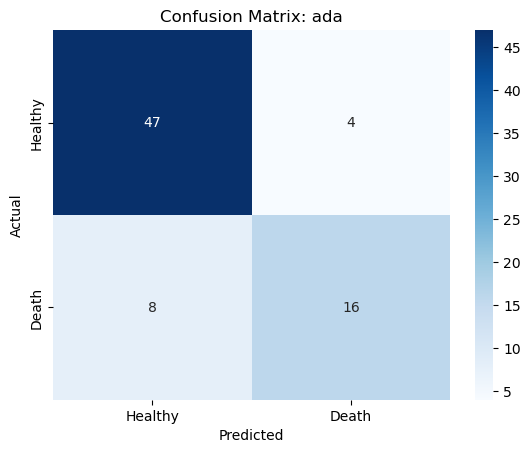

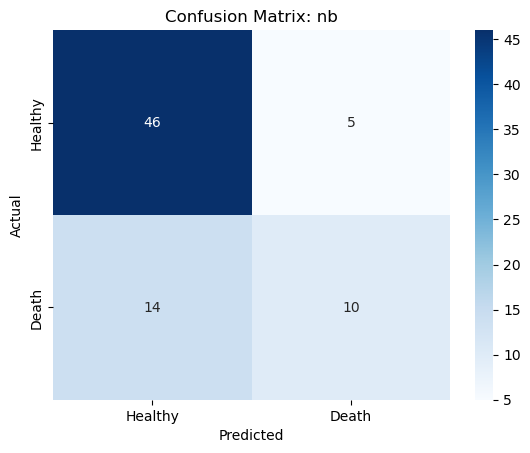

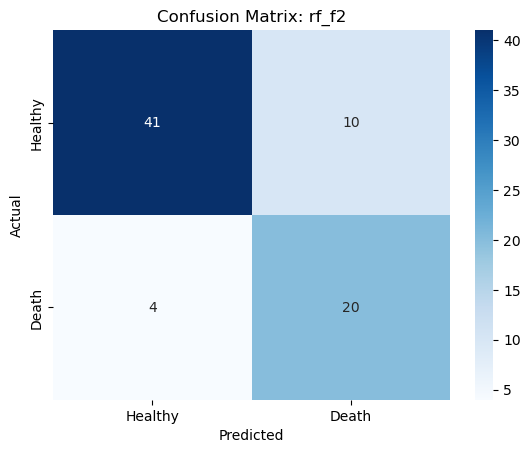

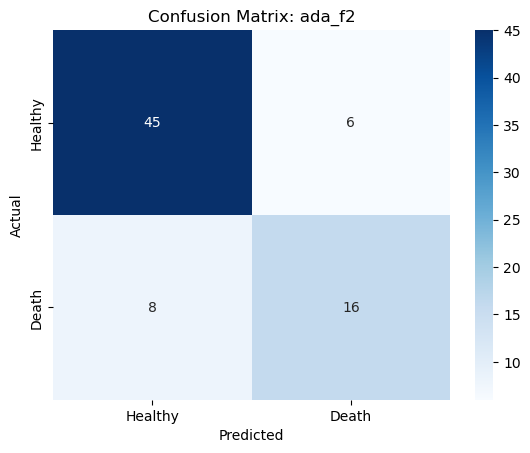


=== Cross-validation (Accuracy ± SD) po tuningu ===

Model: rf
Accuracy: 0.843 ± 0.063
F1: 0.730 ± 0.120
Precision: 0.791 ± 0.107
Recall: 0.693 ± 0.168
AUC: 0.907 ± 0.051

Model: svm
Accuracy: 0.783 ± 0.089
F1: 0.685 ± 0.130
Precision: 0.649 ± 0.132
Recall: 0.730 ± 0.145
AUC: 0.864 ± 0.073

Model: ada


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boos

Accuracy: 0.809 ± 0.074
F1: 0.684 ± 0.135


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boos

Precision: 0.724 ± 0.132
Recall: 0.666 ± 0.174


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boos

AUC: 0.865 ± 0.067

Model: nb
Accuracy: 0.766 ± 0.054
F1: 0.556 ± 0.102
Precision: 0.717 ± 0.122
Recall: 0.459 ± 0.100
AUC: 0.849 ± 0.056

Model: rf_f2
Accuracy: 0.780 ± 0.088
F1: 0.723 ± 0.082
Precision: 0.631 ± 0.108
Recall: 0.863 ± 0.093
AUC: 0.892 ± 0.061

Model: ada_f2
Accuracy: 0.766 ± 0.063
F1: 0.614 ± 0.149
Precision: 0.631 ± 0.104
Recall: 0.621 ± 0.202
AUC: 0.727 ± 0.094


/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boos

,Model,Accuracy (mean),Accuracy (std),F1 (mean),F1 (std),Precision (mean),Precision (std),Recall (mean),Recall (std),AUC (mean),AUC (std)
0,rf,0.842759,0.063447,0.729684,0.119872,0.791090,0.106953,0.693333,0.168303,0.907497,0.051217
1,svm,0.782874,0.089335,0.684718,0.129835,0.649173,0.132059,0.730000,0.144790,0.864029,0.073451
2,ada,0.809080,0.074115,0.684296,0.135167,0.724286,0.132147,0.665556,0.173522,0.865065,0.067046
3,nb,0.765862,0.053803,0.555701,0.101733,0.716548,0.122164,0.458889,0.099759,0.848513,0.056426
4,rf_f2,0.779540,0.088002,0.722565,0.082172,0.630890,0.107731,0.863333,0.093102,0.891608,0.061420
5,ada_f2,0.765632,0.062653,0.613805,0.149222,0.630541,0.103567,0.621111,0.202115,0.726746,0.094120


In [4]:
# print("=== Wyniki dla zbioru heart_1.csv ===")
# results_df = calculations_with_tuning("../dataset/heart_1.csv")

print("\n=== Wyniki dla zbioru heart_2.csv ===")
calculations_with_tuning("../dataset/heart_2.csv")

Rysuje wykresy wszystkich metryk dla każdego modelu, wartości = średnie z cross-validation + odchylenia(std)

In [5]:
import os
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

metrics = ["Accuracy", "F1", "Precision", "Recall", "AUC"]

for metric in metrics:
    plt.figure(figsize=(8,5))
    sns.barplot(x="Model", y=f"{metric} (mean)", data=results_df, palette="viridis", capsize=0.2)
    plt.errorbar(
        x=range(len(results_df)),
        y=results_df[f"{metric} (mean)"],
        yerr=results_df[f"{metric} (std)"],
        fmt='none', c='black', capsize=5
    )
    plt.title(f"{metric} (mean ± std) - Cross-validation")
    plt.ylim(0.7, 1.01)  # not needed smaller than 0.7?
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{metric.lower()}_cv_plot.png")
    plt.close()

NameError: name 'results_df' is not defined

<Figure size 800x500 with 0 Axes>